# Open PTC Agent

This notebook is a demo usage of PTC Agent.

Make sure you have installed the dependencies and configured the api keys in the `.env` file before running the notebook.

In [1]:
import os
import nest_asyncio
from pathlib import Path
from dotenv import load_dotenv

# Get project root (parent of example/)
PROJECT_ROOT = Path(os.path.abspath(".")).parent

load_dotenv(PROJECT_ROOT / ".env", override=True)

# Import utils from current directory (example/)
from utils import (
    show_prompt, format_messages, print_agent_config, print_sandbox_tree, 
    display_sandbox_images, export_sandbox_files, dump_messages
)

# Enable async in Jupyter
nest_asyncio.apply()

from IPython.display import Image, display
from ptc_agent import PTCAgent
from ptc_agent.config import load_from_files
from ptc_agent.core import SessionManager

# Load configuration with explicit paths to project root
config = await load_from_files(
    config_file=PROJECT_ROOT / "config.yaml",
    llms_file=PROJECT_ROOT / "llms.json",
    env_file=PROJECT_ROOT / ".env"
)
config.validate_api_keys()

%load_ext autoreload
%autoreload 2

### Create the PTC Agent

2025-12-09 17:11:03 [info     ] Creating new session           conversation_id=demo-notebook
2025-12-09 17:11:03 [info     ] Created session                conversation_id=demo-notebook
2025-12-09 17:11:03 [info     ] Initializing session           conversation_id=demo-notebook reconnecting=False
2025-12-09 17:11:03 [info     ] Initialized MCPRegistry       
2025-12-09 17:11:03 [info     ] Initialized PTCSandbox        
2025-12-09 17:11:03 [info     ] Setting up sandbox workspace  
2025-12-09 17:11:03 [info     ] Checking for snapshot          snapshot_name=open-ptc-v1-be608dd2
2025-12-09 17:11:03 [info     ] Skipping disabled MCP servers  disabled_servers=['alphavantage']
2025-12-09 17:11:03 [info     ] Connecting to MCP servers      server_count=3
2025-12-09 17:11:03 [info     ] Initialized MCPServerConnector server=tavily
2025-12-09 17:11:03 [info     ] Initialized MCPServerConnector server=tickertick
2025-12-09 17:11:03 [info     ] Initialized MCPServerConnector server=yfinance
202

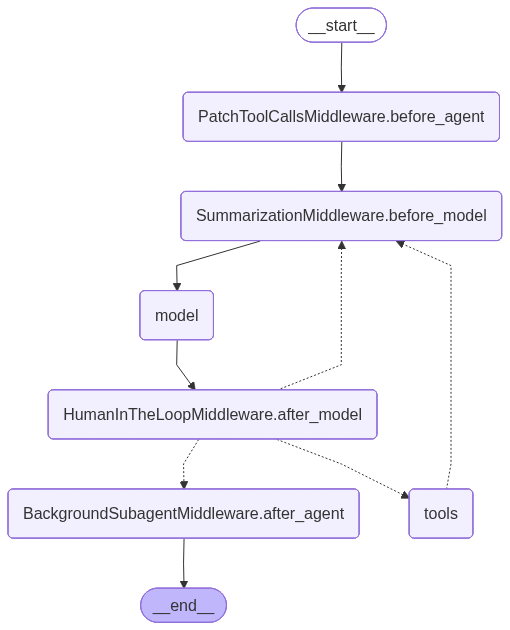

In [2]:
# Change to project root so MCP server relative paths resolve correctly
os.chdir(PROJECT_ROOT)

# Create session with Daytona sandbox
core_config = config.to_core_config()
session = SessionManager.get_session("demo-notebook", core_config)
await session.initialize()

# Create the agent via PTCAgent
ptc_agent = PTCAgent(config)
agent = ptc_agent.create_agent(
    sandbox=session.sandbox,
    mcp_registry=session.mcp_registry,
    subagent_names=["research", "general-purpose"]
)

# Show the agent graph
display(Image(agent.get_graph().draw_mermaid_png()))

In [3]:
# Display agent config with dynamically captured subagent info
print_agent_config(config, session, ptc_agent=ptc_agent)

AGENT CONFIGURATION SUMMARY

📦 LLM CONFIGURATION
----------------------------------------
  Name:      gpt-5.1-codex-mini
  Model ID:  gpt-5.1-codex-mini
  Provider:  openai
  Parameters: {'reasoning': {'effort': 'low', 'summary': 'auto'}}

🔌 MCP SERVERS
----------------------------------------
  tavily: 4 tools
    ['tavily-search', 'tavily-extract', 'tavily-crawl', 'tavily-map']
  tickertick: 7 tools
    ['get_ticker_news', 'get_broad_ticker_news', 'get_news_from_source', 'get_news_for_multiple_tickers', 'get_curated_news', 'get_entity_news', 'search_tickers']
  yfinance: 21 tools
    ['get_stock_history', 'get_income_statement', 'get_balance_sheet', 'get_cash_flow', 'get_options_chain', 'get_company_info', 'get_analyst_recommendations', 'get_institutional_holders', 'get_dividends_and_splits', 'get_earnings_data', 'get_earnings_dates', 'get_insider_transactions', 'get_mutualfund_holders', 'get_sustainability_data', 'get_news', 'get_insider_roster', 'get_multiple_stocks_history', 'com

### Runtime system prompt

In [4]:
# Get the formatted tool summary from MCP registry
tool_summary = ptc_agent._get_tool_summary(session.mcp_registry)

subagent_summary = ptc_agent._get_subagent_summary()
# Build the complete system prompt
system_prompt = ptc_agent._build_system_prompt(tool_summary, subagent_summary)

# Show the complete prompt
print(f"Total prompt length: {len(system_prompt)} characters")
show_prompt(system_prompt, title="PTCAgent Runtime System Prompt", border_style="green")

Total prompt length: 15777 characters


╭──────────────────────────────────────── PTCAgent Runtime System Prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│  For context, today's date is 2025-12-09.                                                                       │
│                                                                                                                 │
│  <task_workflow>                                                                                                │
│  # Task Workflow                                                                                                │
│                                                                                                                 │
│  Follow this workflow for all task requests:                                                                    │
│                                                                                                                 │
│  1. **Save the request**: Use write_file() to save the user's task description to `/results/task_request.md`    │
│  2. **Plan**: Create a todo list with write_todos to break down the task into focused steps                     │
│  3. **Execute**: Delegate subtasks to sub-agents using the task() tool, or execute directly                     │
│  4. **Write Output**: Write comprehensive results to `/results/` directory (see Output Guidelines below)        │
│  5. **Verify**: Read `/results/task_request.md` to confirm you've addressed all aspects of the original         │
│  request                                                                                                        │
│                                                                                                                 │
│  ## Task Planning Guidelines                                                                                    │
│  - Batch similar subtasks into a single TODO to minimize overhead                                               │
│  - For simple tasks, execute directly or use 1 sub-agent                                                        │
│  - For comparisons or multi-faceted tasks, delegate to multiple parallel sub-agents                             │
│  - Each sub-agent should handle one specific aspect and return findings                                         │
│  </task_workflow>                                                                                               │
│                                                                                                                 │
│  <workspace_paths>                                                                                              │
│  # Workspace Structure                                                                                          │
│                                                                                                                 │
│  Working directory: `/home/daytona`                                                                             │
│                                                                                                                 │
│  ## Standard Directories                                                                                        │
│                                                                                                                 │
│  | Directory | Purpose |                                                                                        │
│  |-----------|---------|                                                                                        │
│  | `results/` | Final deliverables (reports, visualizations) |                                                  │
│  | `data/` | Intermediate storage (tool results, API responses) |                                               │
│  | `tools/` | MCP tool modules (auto-generated) |     

### Sandbox workspace preview

In [5]:
# Display sandbox file tree BEFORE agent execution
print("=" * 50)
print("Sandbox File Tree (BEFORE)")
print("=" * 50)
print("./")
print_sandbox_tree(session.sandbox)

Sandbox File Tree (BEFORE)
./
├── code/
├── data/
├── mcp_servers/
│   ├── tickertick_mcp_server.py
│   └── yfinance_mcp_server.py
├── results/
└── tools/
    ├── docs/
    │   ├── tavily/
    │   │   ├── tavily-crawl.md
    │   │   ├── tavily-extract.md
    │   │   ├── tavily-map.md
    │   │   └── tavily-search.md
    │   ├── tickertick/
    │   │   ├── get_broad_ticker_news.md
    │   │   ├── get_curated_news.md
    │   │   ├── get_entity_news.md
    │   │   ├── get_news_for_multiple_tickers.md
    │   │   ├── get_news_from_source.md
    │   │   ├── get_ticker_news.md
    │   │   └── search_tickers.md
    │   └── yfinance/
    │       ├── compare_financials.md
    │       ├── compare_valuations.md
    │       ├── get_analyst_recommendations.md
    │       ├── get_balance_sheet.md
    │       ├── get_cash_flow.md
    │       ├── get_company_info.md
    │       ├── get_dividends_and_splits.md
    │       ├── get_earnings_data.md
    │       ├── get_earnings_dates.md
    │       ├── ge

### Agent execution

In [6]:
# Demo query that explicitly uses subagent delegation
# This query demonstrates:
# - Research subagent: web research for news and analyst opinions
# - General subagent: data processing with MCP tools and visualization
query = """I want you to:
1. Gather some recent news about tsla
2. generate a chart of tsla with 50-day and 200-day moving averages
You should:
- use subagent to finish all the task
- view the generated chart and indeitfy the MCAD crossover
"""
# For purpose of demonstrating new features, we add explicit instructions here

In [7]:
result = await agent.ainvoke(
    {
        "messages": [
            {
                "role": "user",
                "content": query
            }
        ],
    }, 
)

format_messages(result["messages"])

2025-12-09 17:11:13 [info     ] Orchestrator invoking agent    has_messages=True iteration=1
2025-12-09 17:11:16 [info     ] Writing file                   file_path=results/task_request.md normalized_path=/home/daytona/results/task_request.md size=226
2025-12-09 17:11:16 [info     ] Wrote 226 bytes to /home/daytona/results/task_request.md
2025-12-09 17:11:16 [info     ] File written successfully      bytes_written=226 file_path=/results/task_request.md
2025-12-09 17:11:21 [info     ] Globbing files                 normalized_path=/home/daytona path=. pattern=tools/docs/tavily/*.md
2025-12-09 17:11:22 [info     ] Found 4 files matching tools/docs/tavily/*.md
2025-12-09 17:11:22 [info     ] Glob completed successfully    matches=4 path=. pattern=tools/docs/tavily/*.md
2025-12-09 17:11:23 [info     ] Reading file                   file_path=tools/docs/tavily/tavily-search.md limit=400 normalized_path=/home/daytona/tools/docs/tavily/tavily-search.md offset=0
2025-12-09 17:11:23 [info     

[VIEW_IMAGE] URL validation failed: https://zexi-dev.s3.us-east-1.amazonaws.com/charts/exec_0003/tsla_moving_avg_macd.png


2025-12-09 17:12:37 [info     ] Reading file                   file_path=results/task_request.md limit=400 normalized_path=/home/daytona/results/task_request.md offset=0
2025-12-09 17:12:37 [info     ] Read file range                file_path=/home/daytona/results/task_request.md limit=400 lines_read=4 offset=1
2025-12-09 17:12:37 [info     ] File read successfully         file_path=results/task_request.md lines=4 size=225


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want you to:                                                                                                  │
│ 1. Gather some recent news about tsla                                                                           │
│ 2. generate a chart of tsla with 50-day and 200-day moving averages                                             │
│ You should:                                                                                                     │
│ - use subagent to finish all the task                                                                           │
│ - view the generated chart and indeitfy the MCAD crossover                                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "results/task_request.md",                                                                       │
│   "content": "User request:\n1. Gather recent news about TSLA.\n2. Generate a chart of TSLA with 50-day and     │
│ 200-day moving averages, view the chart, and identify the MACD crossover.\nAdditional requirement: Use a        │
│ subagent to finish all tasks.\n"                                                                                │
│ }                                                                                                               │
│    ID: call_suEghCUCQzKHkMJrwsDWv3OC                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote 226 bytes to /results/task_request.md                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Coordinate subagent to collect recent TSLA news, retrieve price data, and generate analysis   │
│ artifacts.",                                                                                                    │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Review outputs from subagent, interpret results, and prepare narrative plus chart             │
│ verification notes.",                                                                                           │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_5wF4g0Wr19tjCSPye6v3te15                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Coordinate subagent to collect recent TSLA news, retrieve price data, and    │
│ generate analysis artifacts.', 'status': 'in_progress'}, {'content': 'Review outputs from subagent, interpret   │
│ results, and prepare narrative plus chart verification notes.', 'status': 'pending'}]                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: glob                                                                                              │
│    Args: {                                                                                                      │
│   "pattern": "tools/docs/tavily/*.md",                                                                          │
│   "path": null                                                                                                  │
│ }                                                                                                               │
│    ID: call_oLLoA0hBNELhQq7IbRpvgpth                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Found 4 file(s) matching 'tools/docs/tavily/*.md':                                                              │
│ /tools/docs/tavily/tavily-extract.md                                                                            │
│ /tools/docs/tavily/tavily-search.md                                                                             │
│ /tools/docs/tavily/tavily-crawl.md                                                                              │
│ /tools/docs/tavily/tavily-map.md                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "tools/docs/tavily/tavily-search.md",                                                            │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_FSY74mTsgupmq7VtzDO0yQPd                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# tavily_search(query: str, search_depth: str = basic, topic: str = general, days: float = 3,            │
│ time_range: str = None, start_date: str = , end_date: str = , max_results: float = 10, include_images: bool =   │
│ False, include_image_descriptions: bool = False, include_raw_content: bool = False, include_domains: List = [], │
│ exclude_domains: List = [], country: str = , include_favicon: bool = False)                                     │
│      2→                                                                                                         │
│      3→A powerful web search tool that provides comprehensive, real-time results using Tavily's AI search       │
│ engine. Returns relevant web content with customizable parameters for result count, content type, and domain    │
│ filtering. Ideal for gathering current information, news, and detailed web content analysis.                    │
│      4→                                                                                                         │
│      5→## Parameters                                                                                            │
│      6→                                                                                                         │
│      7→- `query` (string) - **Required**                                                                        │
│      8→  Search query                                                                                           │
│      9→                                                                                                         │
│     10→- `search_depth` (string) - Optional                                                                     │
│     11→  The depth of the search. It can be 'basic' or 'advanced'                                               │
│     12→                                                                                                         │
│     13→- `topic` (string) - Optional                                                                            │
│     14→  The category of the search. This will determine which of our agents will be used for the search        │
│     15→                                                                                                         │
│     16→- `days` (number) - Optional                                                                             │
│     17→  The number of days back from the current date to include in the search results. This specifies the     │
│ time frame of data to be retrieved. Please note that this feature is only available when using the 'news'       │
│ search topic                                                                                                    │
│     18→                                                                                                         │
│     19→- `time_range` (string) - Optional                                                                       │
│     20→  The time range back from the current date to include in the search results. This feature is available  │
│ for both 'general' and 'news' search topics                                                                     │
│     21→                                                                                                         │
│     22→- `start_date` (string) - Optional                                                                       │
│     23→  Will return all results after the specified start date. Required to be written in the format           │
│ YYYY-MM-DD.                                                                                                     │
│     24→                                                                                                         │
│     25→- `end_date` (string) - Optional                

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Gather the latest news about Tesla (TSLA) from reputable sources and summarize at least three │
│ recent articles. Use tavily_search (news topic) covering the past few days. Retrieve TSLA price history,        │
│ compute 50-day and 200-day moving averages along with MACD (12/26/9), and generate a chart overlaying the       │
│ moving averages and MACD indicator. Save the chart to the results directory. Also identify and describe any     │
│ MACD crossover observed around the latest data. Provide summaries and reference sources for the news and data   │
│ findings.",                                                                                                     │
│   "subagent_type": "general-purpose"                                                                            │
│ }                                                                                                               │
│    ID: call_JNWGQQhZaoMQsGsBnzPdEN5S                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Background subagent deployed: **Task-1**                                                                        │
│ - Type: general-purpose                                                                                         │
│ - Task: Gather the latest news about Tesla (TSLA) from reputable sources and summarize at least three recent    │
│ articles. Use tavily_search (news topic) covering the past few days.                                            │
│ - Status: Running in background                                                                                 │
│                                                                                                                 │
│ You can:                                                                                                        │
│ - Continue with other work                                                                                      │
│ - Use `task_progress(task_number=1)` to monitor progress                                                        │
│ - Use `wait(task_number=1)` to get results when ready                                                           │
│ - Use `wait()` to wait for all background tasks                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: wait                                                                                              │
│    Args: {                                                                                                      │
│   "task_number": 1,                                                                                             │
│   "timeout": 120.0                                                                                              │
│ }                                                                                                               │
│    ID: call_j8ZcMqPwQXyGtEEzYfAHTA7S                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **Task-1** (general-purpose) completed:                                                                         │
│                                                                                                                 │
│ **Summary of Recent Tesla (TSLA) News (via Tavily Search, past few days)**                                      │
│ 1. **Mixed sentiment entering 8 Dec trading** – *TS2.tech* notes Tesla was near all-time highs yet facing       │
│ headwinds: a multibillion-dollar legal risk tied to Elon Musk’s pay, a Cybertruck rollout missing expectations, │
│ weakening European demand, and the possibility that its 2026 Full Self-Driving (FSD) bet in Europe becomes a    │
│ regulatory challenge. The article also reports Tesla quietly dropped a lower-priced Model 3 variant in parts of │
│ Europe amid a “market share collapse,” underscoring the tension between optimism on AI/robotaxi catalysts and   │
│ fading EV demand.                                                                                               │
│    Source: https://ts2.tech/en/tesla-stock-today-tsla-what-to-know-before-the-market-opens-on-december-8-2025/  │
│                                                                                                                 │
│ 2. **Morgan Stanley downgrades TSLA on valuation concerns** – *TipRanks* reports Morgan Stanley analyst Andrew  │
│ Percoco cut TSLA from Buy to Hold, arguing that much of Tesla’s non-automotive story is already priced in and   │
│ that the stock trades at about 30× his 2030 EBITDA estimate. Percoco sees downside to his forecasts and prefers │
│ to wait for a better entry, leaving the average price target at $383.54 (≈16% implied downside).                │
│    Source:                                                                                                      │
│ https://www.tipranks.com/news/tesla-stock-tsla-falls-as-morgan-stanley-downgrades-rating-on-valuation-concerns  │
│                                                                                                                 │
│ 3. **Holiday update brings Grok navigation and safety refinements** – *Business Insider* describes Tesla’s 2025 │
│ Holiday Update adding Grok-powered navigation (Grok can now add/edit driving destinations), an alert chime if a │
│ phone key is left behind, and other feature tweaks. The story highlights Tesla’s increasing integration of Elon │
│ Musk’s AI chatbot with its vehicles, while acknowledging Grok still exists on a limited subset of cars with     │
│ adequate processors.                                                                                            │
│    Source: https://www.businessinsider.com/tesla-grok-navigate-directions-update-elon-musk-xai-chatbot-2025-12  │
│                                                                                                                 │
│ *(Additional notable mention: Bloomberg also highlighted Morgan Stanley’s valuation-based downgrade,            │
│ reinforcing the same theme of a “full valuation” that already prices in robotics/AI ambitions.)*                │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Technical / Quantitative Findings (TSLA as of 2025‑12‑09)**                                                   │
│ - **Latest closing price:** $445.17                                                                             │
│ - **50-day moving average:** $435.24                                                                            │
│ - **200-day moving average:** $343.67                  

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: view_image                                                                                        │
│    Args: {                                                                                                      │
│   "urls": [                                                                                                     │
│     "https://zexi-dev.s3.us-east-1.amazonaws.com/charts/exec_0003/tsla_moving_avg_macd.png"                     │
│   ],                                                                                                            │
│   "base64_images": null,                                                                                        │
│   "sandbox_paths": null                                                                                         │
│ }                                                                                                               │
│    ID: call_NeQMTsvjjPVhD2HIzSUgs4Lp                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Failed to load images. 1 URL(s) were inaccessible.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {                                                                                                      │
│   "path": "/home/daytona/results"                                                                               │
│ }                                                                                                               │
│    ID: call_M2b0GMPAU7JNaMF4Wy6Ss4Ch                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ['/home/daytona/results/task_request.md', '/home/daytona/results/tsla_moving_avg_macd.png']                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: view_image                                                                                        │
│    Args: {                                                                                                      │
│   "urls": null,                                                                                                 │
│   "base64_images": null,                                                                                        │
│   "sandbox_paths": [                                                                                            │
│     "results/tsla_moving_avg_macd.png"                                                                          │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_AmBdc1rCHO0gUtpJCJdssj8D                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Loading 1 image(s) for viewing: 1 sandbox file(s)...                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ [Viewing 1 image(s)]                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Coordinate subagent to collect recent TSLA news, retrieve price data, and generate analysis   │
│ artifacts.",                                                                                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Review outputs from subagent, interpret results, and prepare narrative plus chart             │
│ verification notes.",                                                                                           │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_xG1CVTjNORtH4nVp6vljQfNk                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Coordinate subagent to collect recent TSLA news, retrieve price data, and    │
│ generate analysis artifacts.', 'status': 'completed'}, {'content': 'Review outputs from subagent, interpret     │
│ results, and prepare narrative plus chart verification notes.', 'status': 'completed'}]                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "results/task_request.md",                                                                       │
│   "offset": 0,                                                                                                  │
│   "limit": 400                                                                                                  │
│ }                                                                                                               │
│    ID: call_QGzxNkugo10pTQmGhMpX9gC4                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→User request:                                                                                            │
│      2→1. Gather recent news about TSLA.                                                                        │
│      3→2. Generate a chart of TSLA with 50-day and 200-day moving averages, view the chart, and identify the    │
│ MACD crossover.                                                                                                 │
│      4→Additional requirement: Use a subagent to finish all tasks.                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Overview                                                                                                     │
│ TSLA coverage combined recent news from Tavily-powered searches with a technical review of price behavior using │
│ 50-day and 200-day moving averages plus MACD (12,26,9) overlays. All work was completed by the general-purpose  │
│ subagent, culminating in a chart saved as `results/tsla_moving_avg_macd.png`, which was reviewed to confirm the │
│ requested indicators and crossover status.                                                                      │
│                                                                                                                 │
│ ## Recent News on TSLA                                                                                          │
│ Headline narratives are mixed: TS2.tech highlights market anxiety about stretched valuation, legal risks tied   │
│ to Elon Musk’s compensation, and a softer European Model 3 lineup even as the company chases advanced AI and    │
│ FSD initiatives [1]. Morgan Stanley’s downgrade (via TipRanks) reinforces the sense that growth expectations    │
│ and robotaxi hopes may already be priced in, suggesting little upside until fundamentals confirm further        │
│ progress [2]. Meanwhile, the Business Insider report on Tesla’s 2025 Holiday Update shows incremental           │
│ innovation—Grok-assisted navigation improvements and safety refinements—yet notes adoption remains limited to   │
│ vehicles with adequate processors, tempering the near-term impact [3].                                          │
│                                                                                                                 │
│ ## Technical Analysis: Moving Averages and MACD                                                                 │
│ Daily price data (captured through yfinance) show TSLA trading above both the 50-day ($435.24) and 200-day      │
│ ($343.67) moving averages, signaling a continuation of the long-term uptrend. The plotted chart                 │
│ (`results/tsla_moving_avg_macd.png`) overlays the closing price with the two moving averages and presents the   │
│ MACD lines plus histogram. The 50-day average remains comfortably above the 200-day average, reinforcing the    │
│ bullish posture, and the MACD histogram stays positive, supporting the momentum implied by the price location.  │
│                                                                                                                 │
│ ## MACD Crossover Identification                                                                                │
│ MACD (12,26) sits at 4.494 with the 9-period signal at 0.674, producing a positive MACD-minus-signal difference │
│ (~+3.82). The latest session still reflects that the MACD line remains above the signal line, indicating no new │
│ bearish crossover has occurred; the most recent confirmed crossover was the earlier bullish cross when the MACD │
│ rose through the signal line. Thus, while momentum remains firmly positive, there is no fresh crossover signal  │
│ as of the latest available data.                                                                                │
│                                                                                                                 │
│ ### Sources                                                                                                     │
│ [1] TS2.Tech:                                                                                                   │
│ https://ts2.tech/en/tesla-stock-today-tsla-what-to-know-before-the-market-opens-on-december-8-2025/             │
│ [2] TipRanks – Tesla Stock Down as Morgan Stanley Downgrades Rating:                                            │
│ https://www.tipranks.com/news/tesla-stock-tsla-falls-as

In [8]:
# Display sandbox file tree AFTER agent execution
print("=" * 50)
print("Sandbox File Tree (AFTER)")
print("=" * 50)
print("./")
print_sandbox_tree(session.sandbox)

Sandbox File Tree (AFTER)
./
├── code/
│   ├── exec_0001.py
│   ├── exec_0002.py
│   └── exec_0003.py
├── data/
│   ├── tavily_tsla_news.json
│   ├── tsla_history_processed.csv
│   ├── tsla_history_raw.json
│   └── tsla_metrics_summary.json
├── mcp_servers/
│   ├── tickertick_mcp_server.py
│   └── yfinance_mcp_server.py
├── results/
│   ├── task_request.md
│   └── tsla_moving_avg_macd.png
└── tools/
    ├── __pycache__/
    │   ├── __init__.cpython-312.pyc
    │   ├── mcp_client.cpython-312.pyc
    │   ├── tavily.cpython-312.pyc
    │   └── yfinance.cpython-312.pyc
    ├── docs/
    │   ├── tavily/
    │   │   ├── tavily-crawl.md
    │   │   ├── tavily-extract.md
    │   │   ├── tavily-map.md
    │   │   └── tavily-search.md
    │   ├── tickertick/
    │   │   ├── get_broad_ticker_news.md
    │   │   ├── get_curated_news.md
    │   │   ├── get_entity_news.md
    │   │   ├── get_news_for_multiple_tickers.md
    │   │   ├── get_news_from_source.md
    │   │   ├── get_ticker_news.md
    │

📊 results/tsla_moving_avg_macd.png


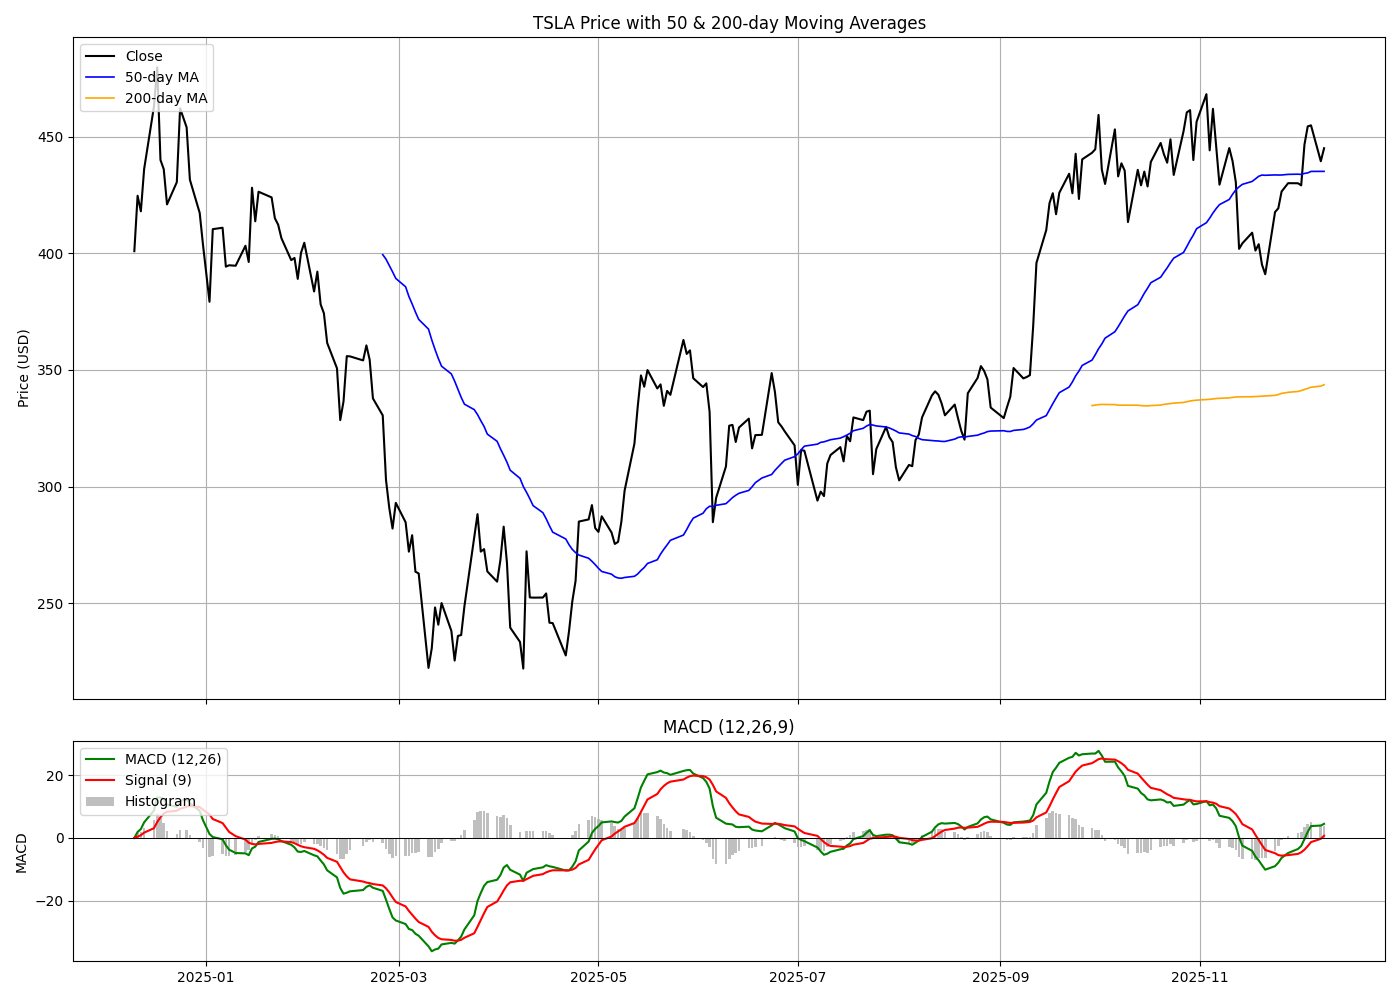


✅ Displayed 1 image(s)


In [9]:
# Display any images generated by the agent
display_sandbox_images(session.sandbox, "results")

In [10]:
# Display code file generated by agent
print("./")
print_sandbox_tree(session.sandbox, path="code/")

./
├── exec_0001.py
├── exec_0002.py
└── exec_0003.py


In [11]:
# Display results generated by agent
print("./")
print_sandbox_tree(session.sandbox, path="results/")

./
├── task_request.md
└── tsla_moving_avg_macd.png


### Export Sandbox Files

Export all files from the sandbox to your local filesystem for inspection or archival.

In [12]:
# Export all sandbox files to local filesystem
# This downloads code/, data/, and results/ directories with timestamp organization
export_result = export_sandbox_files(session.sandbox)

# Dump agent messages to the same output directory for debugging
if export_result.success:
    messages_path = dump_messages(result["messages"], export_result.output_directory)
    print(f"Messages saved to: {messages_path}")

# Display the summary
print(export_result.summary())

📂 Discovering files in 'code'...
   Found 3 file(s)
📂 Discovering files in 'data'...
   Found 4 file(s)
📂 Discovering files in 'results'...
   Found 2 file(s)

✅ Export completed successfully!
   Exported 9 file(s) to: output/20251209_171247
Messages saved to: /Users/chen/projects/open-ptc-agent-feature/output/20251209_171247/messages.json

Export Summary (20251209_171247)
Output Directory: /Users/chen/projects/open-ptc-agent-feature/output/20251209_171247
Total Files: 9
Successfully Exported: 9
Failed: 0
Total Size: 243.99 KB

Directories Processed:
  - code
  - data
  - results



In [13]:
# Alternative: Export only specific directories
# Uncomment and run if you only want to export results
# export_result = export_sandbox_files(
#     session.sandbox,
#     directories=['results'],
#     output_base="my_exports",
#     timestamp_format="%Y-%m-%d_%H-%M"
# )
# print(export_result.summary())

In [14]:
# Cleanup session when done
await session.cleanup()

2025-12-09 17:12:49 [info     ] Cleaning up session            conversation_id=demo-notebook
2025-12-09 17:12:49 [info     ] Cleaning up sandbox            sandbox_id=0b09bba7-ef63-4cdd-a620-1b73dab7e923
2025-12-09 17:12:49 [info     ] Sandbox deleted                sandbox_id=0b09bba7-ef63-4cdd-a620-1b73dab7e923
2025-12-09 17:12:49 [info     ] Disconnecting from all MCP servers
2025-12-09 17:12:49 [info     ] Disconnecting from MCP server  server=tavily
2025-12-09 17:12:49 [info     ] Disconnecting from MCP server  server=tickertick
2025-12-09 17:12:49 [info     ] Disconnecting from MCP server  server=yfinance
2025-12-09 17:12:49 [info     ] Session cleaned up             conversation_id=demo-notebook
